In [1]:
import abc

import torch
from torch.utils.data import DataLoader, Dataset
from tensordict import TensorDict
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MultiHeadSelfAttention(torch.nn.Module):
    def __init__(self, embed_dim:int, n_head:int, is_causal:bool):
        super().__init__()

        self.attention = torch.nn.MultiheadAttention(embed_dim, num_heads=n_head, bias=False, batch_first=True)

        self.is_causal = is_causal

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        context_size = x.shape[1]

        if self.is_causal:
            attention_mask = torch.nn.Transformer.generate_square_subsequent_mask(context_size)
            attention_out, _ = self.attention(x, x, x, need_weights=False, is_causal=True, attn_mask=attention_mask)
        else:
            attention_out, _ = self.attention(x, x, x, need_weights=False)

        return attention_out

In [3]:


class TransformDecoderBlock(torch.nn.Module):
    """
    Block of a Transform Decoder.
    """

    def __init__(self, embed_dim:int, hidden_size:int, n_head:int, 
                 dropout_rate:float=0.0, is_causal:bool=True):
        super().__init__()

        self.is_causal = is_causal

        self.attention = MultiHeadSelfAttention(embed_dim, n_head, self.is_causal)
        self.dropout_attention = torch.nn.Dropout(dropout_rate)
        self.layer_norm1 = torch.nn.LayerNorm(embed_dim)
        self.linear1 = torch.nn.Linear(embed_dim, hidden_size)
        self.dropout_linear1 = torch.nn.Dropout(dropout_rate)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_size, embed_dim)
        self.dropout_linear2 = torch.nn.Dropout(dropout_rate)
        self.layer_norm2 = torch.nn.LayerNorm(embed_dim)



    def forward(self, x:torch.Tensor) -> torch.Tensor:

        #Masked Multi-Head Attention
        y1 = self.dropout_attention(self.attention(x))
        
        #Add & Norm
        y1 = x+y1
        y1 = self.layer_norm1(y1)
        
        #Feed Forward
        y2 = self.dropout_linear1(self.linear1(y1))
        y2 = self.relu(y2)
        y2 = self.dropout_linear2(self.linear2(y2))
        
        #Add & Norm
        result = y1+y2
        result = self.layer_norm2(result)

        return result    

In [4]:
class Modulate(torch.nn.Module):
    def forward(self, x:torch.Tensor, scale:torch.Tensor, shift:torch.Tensor|None=None) -> torch.Tensor:
        if shift is None:
            return x * (1 + scale.unsqueeze(1))
        else:
            return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

In [5]:
class ConditioningBlock(torch.nn.Module, abc.ABC):
    def __init__(self, embed_dim:int, conditioning_dim:int):
        super().__init__()

    @abc.abstractmethod
    def forward(self, x:torch.Tensor, conditioning:torch.Tensor, 
                conditioning_mask:torch.Tensor|None=None) -> torch.Tensor:
        ...

class AdaLNZeroBlock(ConditioningBlock):
    def __init__(self, embed_dim:int, conditioning_dim:int, hidden_size:int, 
                 n_head:int):
        super().__init__(embed_dim, conditioning_dim)

        self.conditioning_mlp = torch.nn.Sequential(torch.nn.SiLU(),
                                                    torch.nn.Linear(conditioning_dim, 6*conditioning_dim, bias=True))

        self.layer_norm1 = torch.nn.LayerNorm(embed_dim)
        self.modulate1 = Modulate()
        self.attention = MultiHeadSelfAttention(embed_dim, n_head)
        self.modulate2 = Modulate()

        self.layer_norm2 = torch.nn.LayerNorm(embed_dim)
        self.modulate3 = Modulate()
        self.linear1 = torch.nn.Linear(embed_dim, hidden_size)
        self.act = torch.nn.GELU(approximate="tanh")
        self.linear2 = torch.nn.Linear(hidden_size, embed_dim)
        self.modulate4 = Modulate()

    def forward(self, x:torch.Tensor, conditioning:torch.Tensor,
                conditioning_mask:torch.Tensor|None=None) -> torch.Tensor:
        
        context_size = x.shape[1]

        if conditioning_mask is None:
            conditioning_mask = torch.ones(context_size, dtype=bool)

        #Conditioning MLP
        gamma1, beta1, alpha1, gamma2, beta2, alpha2 = self.conditioning_mlp(conditioning).chunk(6, dim=1)
        #gamma, alpha: scale
        #beta: shift

        for scale in [gamma1, gamma2, alpha1, alpha2]:
            scale[not conditioning_mask] = 0.0

        for shift in [beta1, beta2]:
            shift[not conditioning_mask] = 0.0

        #First part (before first +)
        y1 = self.layer_norm1(x)
        y1 = self.modulate1(shift=gamma1, scale=beta1)
        y1 = self.attention(y1)
        y1 = self.modulate2(y1, scale=alpha1)

        #First +
        y1 = y1+x

        #Second part
        y2 = self.layer_norm2(y1)
        y2 = self.modulate3(y2, scale=gamma2, shift=beta2)
        
        y2 = self.linear1(y2)
        y2 = self.act(y2)
        y2 = self.linear2(y2)

        y2 = self.modulate4(y2, scale=alpha2) 

        #Second +
        y2 = y2+y1

        return y2


In [6]:
class BlockContainer(torch.nn.Module):
    def __init__(self, block:torch.nn.Module,
                 sensorial_dimension:str=""):
        super().__init__()
        
        self.block = block

        self.sensorial_dimension = sensorial_dimension
    
    def forward(self, x:TensorDict, 
                sensorial_masks:TensorDict) -> TensorDict:

        state = x["state"]
        y = x.copy()

        if self.sensorial_dimension == "":
            y["state"] = self.block(state)
        else:
            sensorial = x[self.sensorial_dimension]
            mask = sensorial_masks[self.sensorial_dimension]
            y["state"] = self.block(state, sensorial, mask)

        return y



In [7]:
class SinePositionalEncoding(torch.nn.Module):
    """
    Positional enconding using sine/cossine function.
    """
    def __init__(self, embed_dim:int, sequence_size:int) -> None:
        """
        Creates the layer.

        Args:
            embed_dim (int): embedding size in the input and output.
            sequence_size (int): size of the sequence in the input and output.
        """

        super().__init__()

        #Caches the positions encodings:
        position = torch.arange(sequence_size, dtype=torch.float32)
        expoent = 2.0*torch.arange(embed_dim, dtype=torch.float32)/embed_dim

        pe = torch.empty((sequence_size, embed_dim))

        pe.T[:] = position
        pe /= torch.pow(1e4, expoent)

        pe[:, 0::2] = torch.sin(pe[:, 0::2])
        pe[:, 1::2] = torch.cos(pe[:, 1::2])

        self.register_buffer("pe", pe)

    def forward(self) -> torch.Tensor:
        """
        Adds the positions encodings to the input.

        Args:
            input_tensor (torch.Tensor): input tensor to receive the positions encodings

        Returns:
            torch.Tensor: input + positional encoding.
        """
        return self.pe

In [78]:
class WorldMachine(torch.nn.Module):
    def __init__(self, state_dim, max_context_size:int):
        super().__init__()

        self.sensorial_encoders : torch.nn.ModuleDict
        self.blocks : torch.nn.ModuleList
        self.sensorial_decoders : torch.nn.ModuleDict

        self.state_encoder : torch.nn.Module = torch.nn.Identity()
        self.state_decoder : torch.nn.Module = torch.nn.Identity()

        self.positional_encoder = SinePositionalEncoding(state_dim, max_context_size)

    def forward(self, sensorial_data:TensorDict, 
                sensorial_masks:TensorDict,
                state:torch.Tensor) -> TensorDict:

        #Sensorial encoding
        x = sensorial_data.copy()        
        for name in self.sensorial_encoders:
            x[name] = self.sensorial_encoders[name](sensorial_data[name])
        
        #State encoding
        x["state"] = self.state_encoder(state) + self.positional_encoder()

        y = x
        #Main prediction+update
        for block in self.blocks:
            y = block(y, sensorial_masks)

        #???
        #y["state"] -= self.positional_encoder()

        #Sensorial decoding from state
        for name in self.sensorial_decoders:
            y[name] = self.sensorial_encoders[name](y["state"])
        
        #State decoding
        y["state_decoded"] = self.state_decoder(y["state"])

        return y

# Teste

In [79]:
t = 0.1

F = np.eye(3)

F[0,1] = t
F[0,2] = np.power(t, 2)/2

F[1, 2] = t

F

array([[1.   , 0.1  , 0.005],
       [0.   , 1.   , 0.1  ],
       [0.   , 0.   , 1.   ]])

In [80]:
n_data = 10000
seq_len = 1000

x = np.zeros((n_data, 3))

data = np.empty((seq_len, n_data, 3))

for i in range(seq_len):
    x = np.dot(F, x.reshape(-1, 3).T).T.reshape(x.shape)

    if i%10 == 0:
        Gu = np.zeros((n_data, 3))
        Gu[:, 2] = (np.random.rand(n_data)-0.5)

        x += Gu

    data[i] = x

data = np.transpose(data, (1, 0, 2))

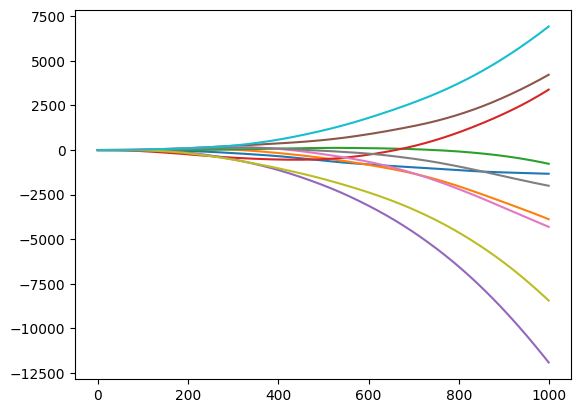

In [81]:
for i in range(10):
    plt.plot(data[i,:,0])

In [82]:
class PredictNextDataset(Dataset):
    def __init__(self, data:np.ndarray, context_size:int):
        super().__init__()

        self.data = data
        self.context_size = context_size

        self.size = data.shape[0]*int(data.shape[1]/context_size)-1

    def __len__(self) -> int:
        return self.size
    
    def _get_item(self, index):
        item_size = data.shape[1]//self.context_size
        item_index = index // item_size
        item_seq_index = index % item_size

        start = item_seq_index*self.context_size
        end = start+self.context_size

        x = self.data[item_index, start:end]


        return torch.Tensor(self.data[item_index, start:end])
    
    def __getitem__(self, index):
        return self._get_item(index), self._get_item(index+1)


In [83]:
def separate_dataset(x_all):
    """
    Separate the data in train, validation and test.

    Args:
        x_all: all dataset elements.

    Returns:
        : train elements. 
        : validation elements.
        : test elements.
    """
    size_all = len(x_all)

    cut1 = int(0.6*size_all)
    cut2 = int(0.8*size_all)

    x_train = x_all[0:cut1]

    x_val = x_all[cut1:cut2]

    x_test = x_all[cut2:]

    return x_train, x_val, x_test

In [84]:
context_size = 200

In [85]:
train_data, val_data, test_data = separate_dataset(data)

datasets = {"train":PredictNextDataset(train_data, context_size), 
            "val":PredictNextDataset(val_data, context_size), 
            "test":PredictNextDataset(test_data, context_size)}

In [86]:
batch_size = 32

In [87]:
dataloaders = {}
for name in datasets:
    dataloaders[name] = DataLoader(datasets[name], batch_size=batch_size, shuffle=True)

In [88]:
wm = WorldMachine(state_dim=3, max_context_size=context_size)

wm.sensorial_encoders = torch.nn.ModuleDict({})
wm.sensorial_decoders = torch.nn.ModuleDict({})

blocks = []
for i in range(3):
    blocks.append(BlockContainer(TransformDecoderBlock(3, 3*4, 1, 0.1, True)))

wm.blocks = torch.nn.Sequential(*blocks)


In [89]:
x, y = next(iter(dataloaders["train"]))

In [96]:
y = wm(TensorDict(batch_size=batch_size), TensorDict(batch_size=batch_size), x)

In [101]:
y[0]["state"]

tensor([[-1.3929e+00,  9.0806e-01,  4.8488e-01],
        [-1.4089e+00,  5.9838e-01,  8.1052e-01],
        [-1.3324e+00,  1.0766e+00,  2.5579e-01],
        [-1.2292e+00,  1.2202e+00,  9.0372e-03],
        [-1.0750e+00,  1.3333e+00, -2.5826e-01],
        [-1.4081e+00,  8.1815e-01,  5.8990e-01],
        [-1.3448e+00,  1.0514e+00,  2.9342e-01],
        [-1.3170e+00,  1.1048e+00,  2.1220e-01],
        [-1.3066e+00,  1.1219e+00,  1.8476e-01],
        [-1.3397e+00,  1.0621e+00,  2.7756e-01],
        [-1.4108e+00,  7.8998e-01,  6.2085e-01],
        [-1.4038e+00,  8.4991e-01,  5.5393e-01],
        [-1.4026e+00,  5.4489e-01,  8.5774e-01],
        [-1.2662e+00,  1.1786e+00,  8.7539e-02],
        [-1.3558e+00,  1.0261e+00,  3.2973e-01],
        [-1.3915e+00,  9.1445e-01,  4.7703e-01],
        [-1.2287e+00,  1.2208e+00,  7.9080e-03],
        [-1.3145e+00,  1.1090e+00,  2.0547e-01],
        [-1.3621e+00,  1.0105e+00,  3.5155e-01],
        [-1.2986e+00,  1.1344e+00,  1.6421e-01],
        [-1.2266e+00

- Colocar encoder e decoder como MLP
- Treino usando estados pré-conhecidos (x e y que temos)
- Adicionar dados sensoriais (H(x_i))
- Treinar com dados sensoriais
- Treinar com ruído
- Model builder